In [2]:
import geometry
import scale_transform
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json

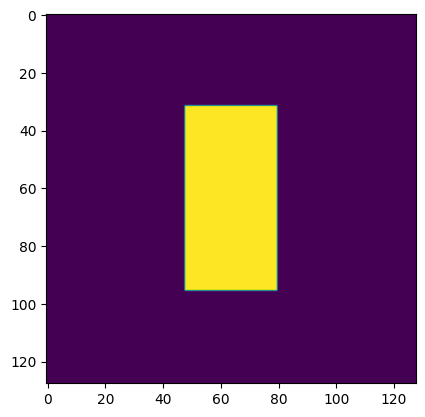

In [40]:
# test case: 128*128*128 matrix with 64^3 in the center
num_slices = 5

test_1 = np.zeros((128, 128, 128))
test_1[32:96, 48:80, 32:96] = 200
test_2=np.ones((128,128,128))
for i in range(128):
    for j in range(128):
        for k in range(128):
            if ((i-64)**2+(j-64)**2+(k-64)**2)**0.5>50:
                test_2[i,j,k]=0
                
plt.imshow(test_1[:,:,64])

In [39]:
angle_list = [(0,0,0), (np.pi/2,0,0), (0,np.pi/2,0), (0,0,np.pi/2), (np.pi/4,0,0), (0,np.pi/4,0), (0,0,np.pi/4), (np.pi/8,0,0), (0,np.pi/8,0), (0,0,np.pi/8)]
transform_list = []
slices_list = []

for a in angle_list:
    transform_list.append(geometry.Transform(a, translation=(0, 0, 0)))

for a, t in enumerate(transform_list):
    transformed_img = scale_transform.global_to_local(test_1, t)
    slice_transformed_img = transformed_img[:,:,transformed_img.shape[2]//2]
    cv2.imwrite(f'slices_for_prompting/slice_{a}.png', slice_transformed_img)

    slice_info = dict()
    slice_info['idx'] = transformed_img.shape[2]//2
    slice_info['transform'] = t
    slice_info['shape'] = transformed_img.shape
    slices_list.append(slice_info)



In [ ]:


# load image files and save prompt points



In [ ]:
# get test matrix

# get the list of transforms

# slice the matrix using global_to_local function. Do it to every transform.

# Add prompting:
    # save slices to image files (naming convention: 001.png)
    # open image files and save prompt points to jason 

# convert prompt points to zero_centric coordinates using index_to_coord

# for each transform:
    # calculate the rotated array
    # for n slices:
        # get the slice of the rotated array,
        # calculate the prompts intersecting with that slice
        # feed into SAM inference function
        # Get mask points for that slice
        # Convert to global coord, append to list of global mask points
        
# take global mask points, convert to volumetric mask

In [4]:
# parsing
# pos_points = [[], [], [], ...]
# neg_points = [[], [], [], ...]
prompt_points = json.load(open('test_data.json'))
pos_polylines = []
neg_polylines = []

for prompt in prompt_points:
    if prompt['label'] == 1:
        pos_points.append(prompt['point'])
    else:
        neg_points.append(prompt['point'])




{'img': 'C:\\Users\\aarus\\Downloads\\slices_for_prompting/slice_0.png',
 'pos_polylines': [[[103, 84, 0], [99, 124, 0], [119, 113, 0]]],
 'neg_polylines': [[[198, 158, 0], [160, 187, 0], [72, 187, 0], [44, 111, 0]],
  [[67, 56, 0], [155, 19, 0], [181, 63, 0]]]}

In [ ]:
# get pos, neg line segments

pos_seg = []
neg_seg = []

for i, s in enumerate(slices_list):
    idx = s['idx']
    shape = s['shape']
    transform_curr = s['transform']
    pos_points_curr = pos_points[i]
    neg_points_curr = neg_points[i]

    global_pos_points = [scale_transform.coord_to_index(np.array(p).append(idx), transform_curr, shape) for p in pos_points_curr]
    global_neg_points = [scale_transform.coord_to_index(np.array(p).append(idx), transform_curr, shape) for p in neg_points_curr]

    for i in len(global_pos_points):
        pos_seg.append([global_pos_points[i], global_pos_points[i + 1]])
        if i == len(global_pos_points) - 1:
            break
    for i in len(global_neg_points):
        neg_seg.append([global_neg_points[i], global_neg_points[i + 1]])
        if i == len(global_neg_points) - 1:
            break

    

In [ ]:
for t in transform_list:
    transformed_img = scale_transform.global_to_local(test_1, t)
    
    z_coord_list = np.linspace(0, transformed_img.shape[2], num_slices + 1, endpoint=False, dtype=int)[1:-1]  
    for z in z_coord_list:
        slice_transformed_img = transformed_img[:,:,z]
        
        # calculate intersection points
        pos_intersects = []
        neg_intersects = []

        for p in pos_seg:
            pos_intersects.append(scale_transform.get_intersection_point(p[0], p[1], z))
        for n in neg_seg:
            neg_intersects.append(scale_transform.get_intersection_point(n[0], n[1], z))
        
        # feed into SAM inference function``


the notebook we will use


